In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

import numpy as np

sample_rate = 48000
tau = 2.0 * np.pi

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_spectrum(signal, sample_rate):
    # http://samcarcagno.altervista.org/blog/basic-sound-processing-python/
    size = len(signal)
    fft_res = np.fft.fft(signal)
    fft_unique_points = int(ceil((size+1)/2.0))
    p = abs(fft_res[0:fft_unique_points])
    p = p / float(size)
    p = p ** 2
    if size % 2 == 1:
        p[1:len(p)] = p[1:len(p)] * 2
    else:
        p[1:len(p) - 1] = p[1:len(p) - 1] * 2
    freq_axis_array = arange(0, fft_unique_points, 1.0) * (sample_rate / size)
    plot(freq_axis_array/1000, 10*log10(p))
    #xscale('log')
    #xlim(xmin=20)
    xlabel('Frequency (kHz)')
    ylabel('Power (dB)')

# Additive Saw

In [3]:
def gen_additive_saw(osc_freq, sample_rate, nsamples):
    nyquist = sample_rate / 2.0
    harmonics = (osc_freq * x for x in range(1, int(math.ceil(nyquist / osc_freq))))
    
    end_phases = [((tau * f) / sample_rate) * nsamples
                  for f in harmonics]
    
    return np.sum([np.sin(np.linspace(0, end_phase, nsamples)) / (i + 1.0)
                   for (i, end_phase) in enumerate(end_phases)], axis=0) / 2.0

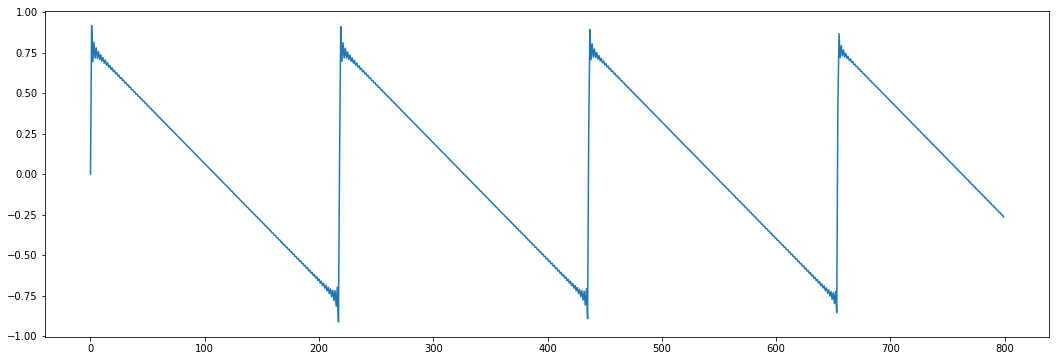

In [4]:
plot(gen_additive_saw(220, sample_rate, 800))

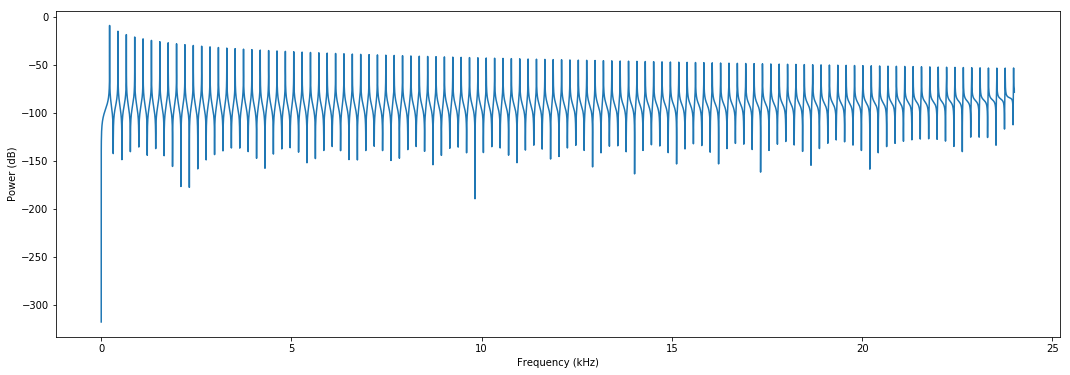

In [5]:
plot_spectrum(gen_additive_saw(220, sample_rate, 48000), sample_rate)

# Naive saw

In [6]:
def gen_naive_saw(osc_freq, sample_rate, nsamples):
    end_phase = (osc_freq / float(sample_rate)) * nsamples
    return 2.0 * (0.5 - np.mod(np.linspace(0, end_phase, nsamples), 1.0))

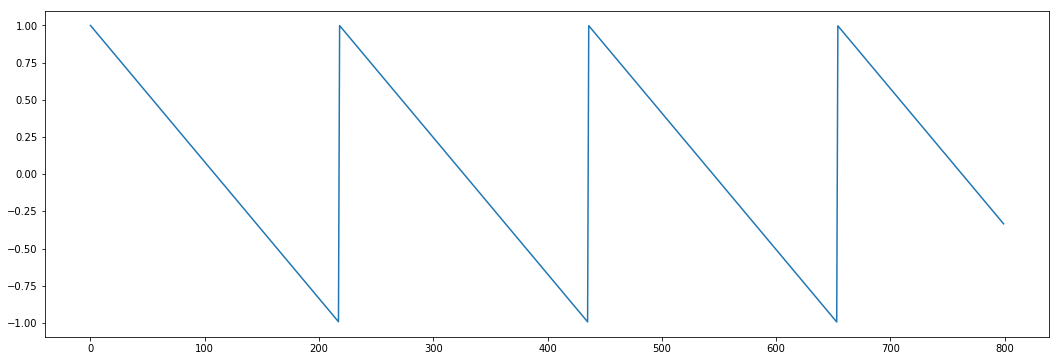

In [7]:
plot(gen_naive_saw(220, sample_rate, 800))

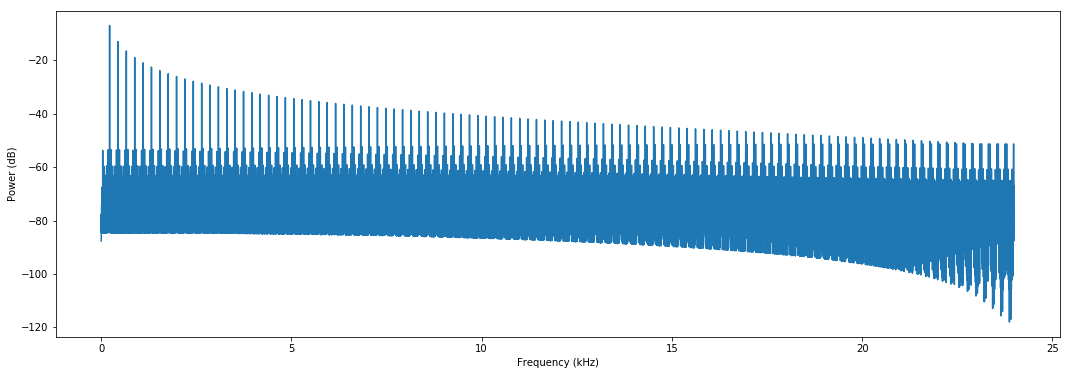

In [8]:
plot_spectrum(gen_naive_saw(220, sample_rate, 48000), sample_rate)

# 2-point polyBLEP

In [9]:
def polyblep_2sample(phase, phase_step):
    if phase < phase_step:
        t = phase / phase_step
        return (t*2) - (t**2) - 1.0
    
    if phase > (1.0 - phase_step):
        t = (phase - 1.0) / phase_step
        return (t**2) + (t*2) + 1.0
    
    return 0.0

def gen_polyblep_saw(osc_freq, sample_rate, nsamples):
    end_phase = (osc_freq / float(sample_rate)) * nsamples
    
    phases = np.mod(np.linspace(0, end_phase, nsamples), 1.0)
    
    step = phases[1] - phases[0]
    polyblep = [polyblep_2sample(x, step) for x in phases]
    
    return (1.0 - (2.0 * phases)) + polyblep

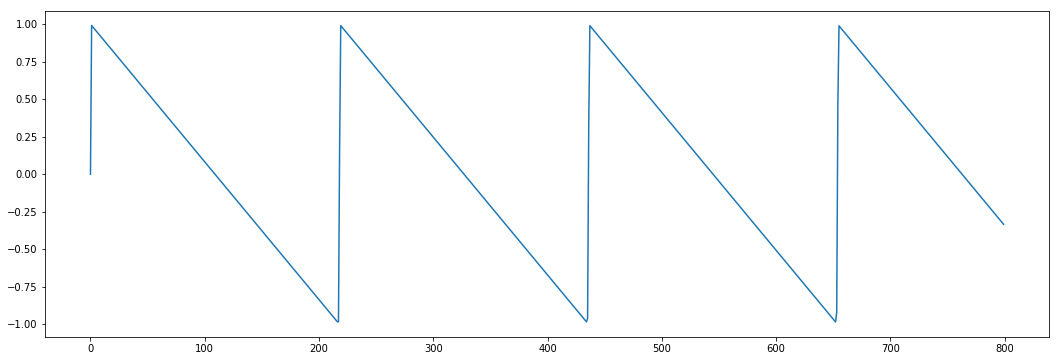

In [10]:
plot(gen_polyblep_saw(220, sample_rate, 800))

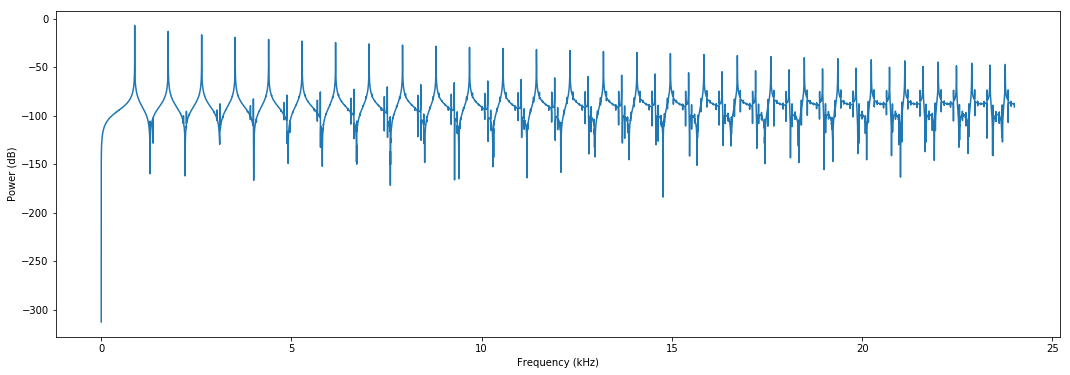

In [11]:
plot_spectrum(gen_polyblep_saw(880, sample_rate, 48000), sample_rate)

# 2x Oversampled 2-point polyBLEP

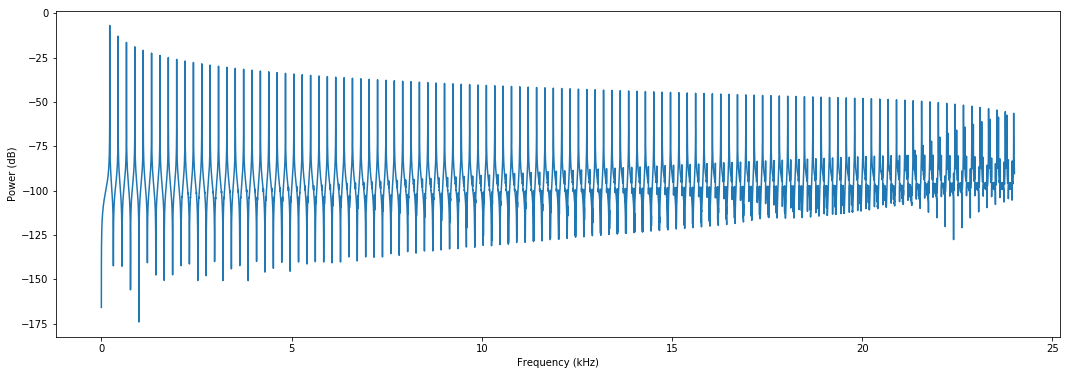

In [12]:
import scipy.signal

plot_spectrum(
    scipy.signal.resample_poly(gen_polyblep_saw(220, sample_rate * 2, 96000), 1, 2),
    sample_rate)

##### (hey let's see that additive one again just for reference)

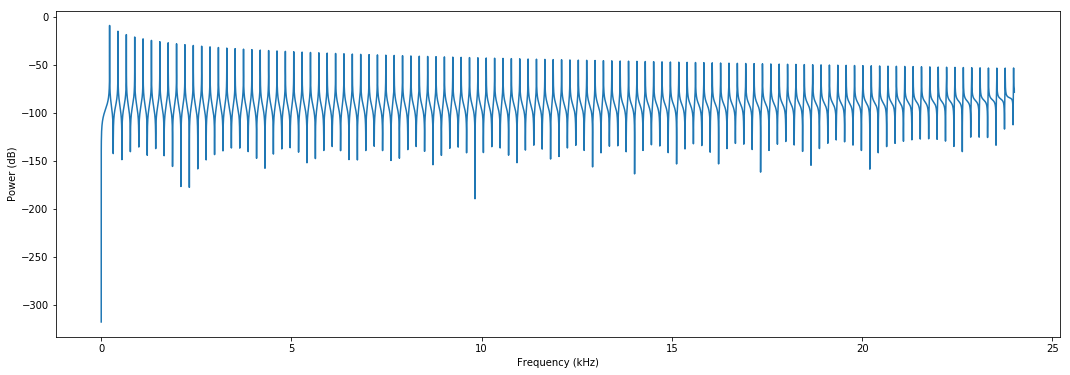

In [13]:
plot_spectrum(gen_additive_saw(220, sample_rate, 48000), sample_rate)

***(all together now!)***

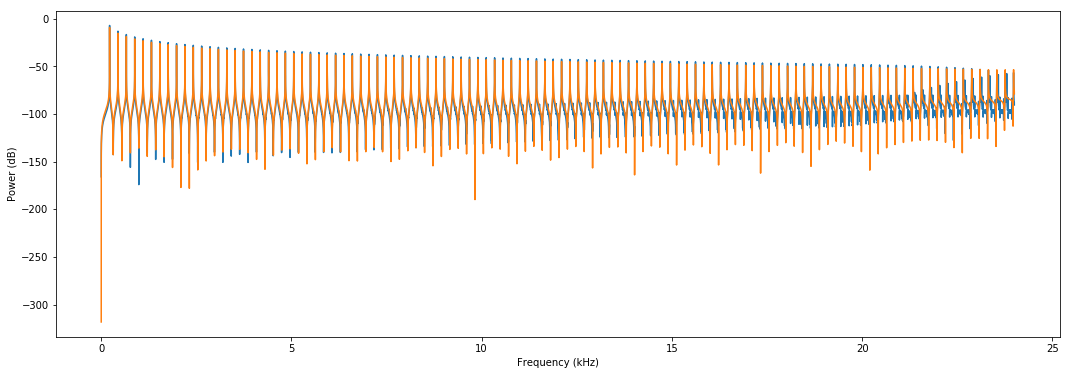

In [21]:
plot_spectrum(
    scipy.signal.resample_poly(gen_polyblep_saw(220, sample_rate * 2, 96000), 1, 2),
    sample_rate)
plot_spectrum(gen_additive_saw(220, sample_rate, 48000), sample_rate)

In [32]:
from IPython.display import Audio

freq = 3520
seconds = 4

In [33]:
Audio(gen_additive_saw(freq, sample_rate, sample_rate * seconds), rate=sample_rate)

In [34]:
Audio(gen_naive_saw(freq, sample_rate, sample_rate * seconds), rate=sample_rate)

In [35]:
Audio(gen_polyblep_saw(freq, sample_rate, sample_rate * seconds), rate=sample_rate)

In [36]:
Audio(
    scipy.signal.resample_poly(gen_polyblep_saw(freq, sample_rate * 2, sample_rate * 2 * seconds), 1, 2),
    rate=sample_rate)